In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Binance API parameters
traded_assets = ['BTC']#, 'ETH', 'ADA', 'DOGE']
stable_assets = ['USDT']
start_date = "Jan 01, 2021"
end_date = "Dec 31, 2021"
time_horizons = ['1hr']#, '12hr', '1wk']

# EMA parameters
# alpha_values = [0.25]#, 0.5, 0.75]
span = 13 

# labeling parameters
trend_reversal_tresholds = [0.3]
change_tolerances = [0.5, 1]
forward_terms = [10]

In [3]:
for traded_asset in traded_assets:
    for stable_asset in stable_assets:
        for time_horizon in time_horizons:
            # for alpha_value in alpha_values:
            df = pd.read_csv(f"data/{traded_asset}_{stable_asset}_{time_horizon}_{0.5}_ema.csv")

In [4]:
df['close_ema'] = df['close'].ewm(span=span).mean()

In [5]:
def percentage_change(start_index, end_index, df):
    # Given two indicies, return the percentage change at the second index form the first index
    return 100 * (df.loc[end_index, 'close_ema'] - df.loc[start_index, 'close_ema']) / df.loc[start_index, 'close_ema']

In [6]:
def check_exit_long(first_index, second_index, forward_term, trend_reverse_factor, change_tolerance, df):
    """
        Checks whether the trend from first_index to second_index is broken, return True if there is a reversal

        trend_reversal occurs when 
        * trend from second_index to second_index+(upto forward_term) < trend first_index to second_index
        second_index >= first_index + 1

        eg: first_index = 3, 
            second_index = 11, 
            trend from index 3 to 10 = 1.5 (% change), 
            forward_term = 10,
            trend_reversal_factor = 0.3,
            change_tolerance = 0.5

            anytime from index 11 to index 21 if the percentage change <= -0.45, then
            we conclude that the trend reverses at index 11

            in case there are hard turns to the other direction (down trend) in index 4, 5 or
            somewhere around index x, it might be due to the natural volatility of cryptocurrency market
            and the actual trend might be kept intact in later indices. For this reason, we check to see
            if the change from 3 to 11 is greater than a given change_tolerance (0.5) down.            
    """
    
    # the increase in closing price EMA from current candle to the next (eg: increase from time=14:00 -> 15:00)
    root_increase = percentage_change(start_index=first_index, end_index=second_index, df=df)

    current_change = root_increase
    next_point_index = second_index

    i = 0
    # for the totality of our forward term or until current change reverses to negative 
    while (i < forward_term) or (current_change < 0):
        next_point_index += 1

        # avoid 
        if next_point_index > len(df) - 1:
            break

        current_change = percentage_change(start_index=second_index, end_index=next_point_index, df=df)
        
        if current_change <= -(root_increase*trend_reverse_factor):
            if abs(percentage_change(start_index=first_index, end_index=second_index, df=df)) > change_tolerance:
                return True

        i += 1
    
    return False

In [7]:
def check_exit_short(first_index, second_index, forward_term, trend_reverse_factor, change_tolerance, df):
    """
        Checks whether the trend from first_index to second_index is broken, return True if there is a reversal

        trend_reversal occurs when 
        * trend from second_index to second_index+(upto forward_term) > trend first_index to second_index
        second_index >= first_index + 1

        eg: first_index = 3, 
            second_index = 11, 
            trend from index 3 to 10 = -1.5 (% change), 
            forward_term = 10,
            trend_reversal_factor = 0.3,
            change_tolerance = 0.5

            anytime from index 11 to index 21 if the percentage change >= 0.45, then
            we conclude that the trend reverses at index 11

            in case there are hard turns to the other direction (down trend) in index 4, 5 or
            somewhere around index x, it might be due to the natural volatility of cryptocurrency market
            and the actual trend might be kept intact in later indices. For this reason, we check to see
            if the change from 3 to 11 is greater than a given change_tolerance (0.5) down.            
    """
        
    root_decrease = percentage_change(start_index=first_index, end_index=second_index, df=df)

    current_change = root_decrease
    next_point_index = second_index
    
    i = 0
    while (i < forward_term) or (current_change > 0):
        next_point_index += 1

        if next_point_index > len(df)-1:
                break

        current_change = percentage_change(start_index=second_index, end_index=next_point_index, df=df)

        if current_change >= -(root_decrease*trend_reverse_factor):
            if abs(percentage_change(start_index=first_index, end_index=second_index, df=df)) > change_tolerance:
                return True
            
        i += 1

    return False

In [8]:
trend_reverse_factor = 1
change_tolerance = 1
forward_term = 10

# create initial position with ema
if df.loc[0, 'close_ema'] < df.loc[1, 'close_ema']:
    df.loc[0, 'position'] = 1
else:
    df.loc[0, 'position'] = 0

time_n = 0
time_n_1 = 1

while (time_n < span) and (time_n_1 < span):
    # if entry
    if df.loc[time_n, 'position'] == 1:
        # if in long
        # unitl we get a trend reversal, we continue holding the position
        while check_exit_long(first_index=time_n, second_index=time_n_1, forward_term=forward_term, trend_reverse_factor=trend_reverse_factor, change_tolerance=change_tolerance, df=df) == False:
            time_n_1 += 1
            if time_n_1 > span:
                break
        
        # enter new position (short)
        df.loc[time_n_1, 'position'] = 0

        # update indices to new position indices
        time_n = time_n_1
        time_n_1 += 1
    else:
        # if in short
        # until we get a trend reversal, we continue holding the position
        while check_exit_short(first_index=time_n, second_index=time_n_1, forward_term=forward_term, trend_reverse_factor=trend_reverse_factor, change_tolerance=change_tolerance, df=df) == False:
            time_n_1 += 1
            if time_n_1 > span:
                break
            
        # enter new position
        df.loc[time_n_1, 'position'] = 1

        # update indices to new position indices
        time_n = time_n_1
        time_n_1 += 1

In [9]:
df

,open,close,closeTime,close_ema,close_time_parsed,position
0,28923.63,28995.13,1609462799999,28995.130000,2021-01-01 00:59:59,1.0
1,28995.13,29409.99,1609466399999,29218.516154,2021-01-01 01:59:59,NaN
2,29410.00,29194.65,1609469999999,29209.307953,2021-01-01 02:59:59,NaN
3,29195.25,29278.40,1609473599999,29230.754624,2021-01-01 03:59:59,NaN
4,29278.41,29220.31,1609477199999,29227.977795,2021-01-01 04:59:59,NaN
...,...,...,...,...,...,...
8719,47558.35,47203.16,1640897999999,47355.996546,2021-12-30 20:59:59,NaN
8720,47203.16,47300.00,1640901599999,47347.997039,2021-12-30 21:59:59,NaN
8721,47299.99,47084.88,1640905199999,47310.408891,2021-12-30 22:59:59,NaN
8722,47084.88,47120.87,1640908799999,47283.331906,2021-12-30 23:59:59,NaN


In [14]:
"""
long_utility: the utility value if stategy takes long at that price
"""
i = len(df) - 1
inflection_point_index = i

while i >= 0:
    if pd.isnull(df.loc[i, 'position']):
        df.loc[i, 'long_utility'] = df.loc[inflection_point_index, 'close_ema'] - df.loc[i, 'close_ema']
    else:
        inflection_point_index = i
        df.loc[i, 'long_utility'] = df.loc[inflection_point_index, 'close_ema'] - df.loc[i, 'close_ema']

    i -= 1

df.loc[len(df)-1, 'long_utility'] = 0 # to make the scale of the graph of long_utility equal wit the rest

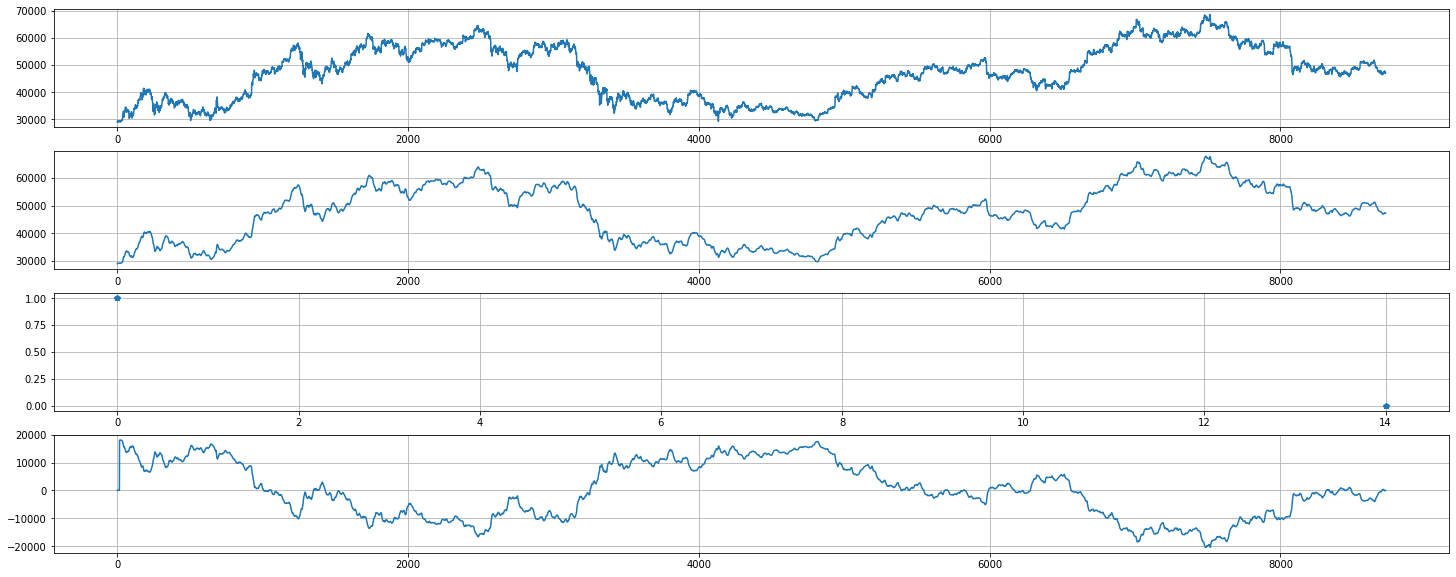

In [15]:
plt.figure(figsize=(25, 10))
plt.subplot(411)
plt.plot(df['close'])
plt.grid()

plt.subplot(412)
plt.plot(df['close_ema'])
plt.grid()

plt.subplot(413)
plt.plot(df['position'] ,'-p')
plt.grid()

plt.subplot(414)
plt.plot(df['long_utility'])
plt.grid()